# FEATURE SELECT AND CLASSIFIER

#### Autor: Leandro Almeida    
Email: leandrofalmeida@gmail.com  s etapas_ 

In [1]:
# Bibliotecas utilizadas
import warnings
import shap
import ast
import csv

import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from IPython.display import display
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

pd.set_option('future.no_silent_downcasting', True)

warnings.filterwarnings("ignore")

In [2]:
# Leitura dos dados
df_x = pd.read_csv('dados/X.csv', index_col = 0, low_memory=False)
df_y = pd.read_csv('dados/Y.csv', index_col = 0)

In [3]:
# Verificando dimensão dos dataframe
print(df_x.shape)
print(df_y.shape)

(4746, 3249)
(4746, 1)


In [4]:
df_x.head()

,F0001,F0002,F0003,F0004,F0005,F0006,F0007,F0008,F0009,F0010,...,F3240,F3241,F3242,F3243,F3244,F3245,F3246,F3247,F3248,F3249
index,,,,,,,,,,,,,,,,,,,,,
{603d7ffa-0804-ef11-9f89-6045bd3ad766},1,MWT5U4J7,HZYQ6FXR,True,True,False,False,True,False,False,...,0,1,1,0,0,1,2,0,0,1
{62461001-2928-ef11-840b-002248e03d77},1,MWT5U4J7,HZYQ6FXR,True,True,True,True,True,True,True,...,0,1,1,1,0,1,2,1,0,1
{c2acfba4-6998-ee11-be37-002248e0b395},0,8NPHCCEI,HZYQ6FXR,True,True,True,True,True,True,True,...,0,1,1,1,0,1,6,4,0,3
{5653ed0e-e0b6-ee11-a569-000d3ac1c7d5},1,MWT5U4J7,RXEQ18HG,True,False,False,False,True,False,False,...,0,2,1,0,0,2,7,0,0,5
{e348f1f7-e728-ef11-840a-6045bd3988ea},0,8NPHCCEI,HZYQ6FXR,True,False,True,True,True,True,True,...,0,4,1,2,0,3,8,9,0,7


In [5]:
df_y.head()

,Target
index,
{603d7ffa-0804-ef11-9f89-6045bd3ad766},1
{62461001-2928-ef11-840b-002248e03d77},1
{c2acfba4-6998-ee11-be37-002248e0b395},1
{5653ed0e-e0b6-ee11-a569-000d3ac1c7d5},1
{e348f1f7-e728-ef11-840a-6045bd3988ea},1


<Axes: xlabel='Target', ylabel='count'>

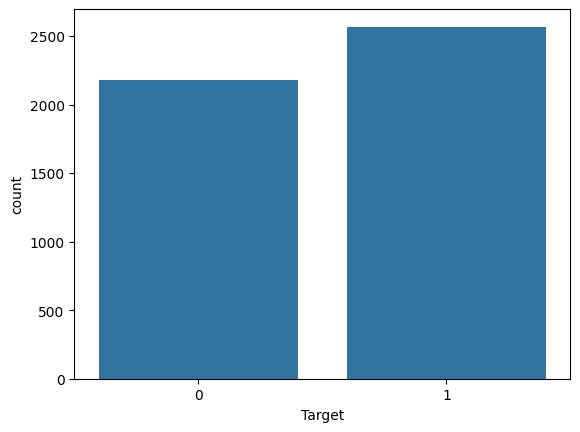

In [6]:
sns.countplot(data = df_y, x = 'Target')

### TRATAMENTO DOS DADOS

#### - FUNÇÕES PARA TRATAMENTO DOS DADOS

In [7]:
#Função para deletar colunas que possuem mais que 75% de seus registros nulos e preenchimento de null para menos que 25% null
def tratamento_colunas_reg_null(df_x):
    nulos_por_coluna = {}
    col_deletar = []
    col_moda = []

    for coluna in df_x.columns:
        nulos_count = df_x[coluna].isnull().sum()
        if (nulos_count / df_x.shape[0]) >= 0.75: 
            col_deletar.append(coluna)
        elif (nulos_count / df_x.shape[0]) <= 0.25: 
            col_moda.append(coluna)
    
    # Deletar colunas que possuem 75% ou mais de valores nulos
    df_x = df_x.drop(columns=col_deletar)

    for col in col_moda:
        moda = df_x[col].mode(dropna=True)
        if not moda.empty:
            valor_moda = moda.iloc[0]
            df_x[col] = df_x[col].fillna(valor_moda)

    print(f"Número de colunas com mais de 75% de registros nulos que foram deletadas: {len(col_deletar)}")
    print(f"Número de colunas com menos de 25% de registros nulos preenchidos com a moda: {len(col_moda)}")
   # print(f"Colunas deletadas: {col_deletar}")
    
    return df_x


#Função para substituir TRUE ou FALSE por 1 ou 0
def substituir_bool_por_int(df):
    for coluna in df.columns:
        if df[coluna].dtype == bool or set(df[coluna].dropna().unique()) <= {True, False}:
            moda = df[coluna].mode()[0]
            df[coluna] = df[coluna].fillna(moda).infer_objects(copy=False)
            df[coluna] = df[coluna].astype(int)
    return df


#Função para retornar a quantidade de colunas por tipo
def contar_tipos_colunas(df):
    tipos = df.dtypes 
    contagem = tipos.value_counts() 
    
    for tipo, quantidade in contagem.items():
        print(f"Tipo: {tipo}, Quantidade de colunas: {quantidade}")
    
    return contagem.to_dict()


#Função para obter resumo informativos das colunas
def resumir_colunas(df, colunas):
    info = []
    total_linhas = df.shape[0]  

    for col in colunas:
        unique_vals = df[col].unique()
        info.append({
            'coluna': col,
            'qtde_registros_nao_nulos': df[col].count(),
            'qtde_registros_nulos': total_linhas - df[col].count(),
            'qtde_valores_unicos': len(unique_vals),
            'valores_unicos': unique_vals
        })

    resumo_df = pd.DataFrame(info)
    return resumo_df


#Função para codificar binários
def codificar_binario(df, colunas_binarias):
    for col in colunas_binarias:
        valores_unicos = df[col].unique()
        if len(valores_unicos) != 2:
            print(f"A coluna '{col}' não possui exatamente 2 valores únicos. Ignorando...")
            continue
            
        map_dict = {valores_unicos[0]: 1, valores_unicos[1]: 2}

        df[col] = df[col].map(map_dict)

        print(f"Coluna: {col}")
        print(f"Valor: {valores_unicos[0]} = 1")
        print(f"Valor: {valores_unicos[1]} = 2")
    
    return df


#Funçao para preencher valores NAN com a Moda da coluna
def preencher_nans_categoricos(df, colunas):
    for col in colunas:
        moda = df[col].mode(dropna=True)[0]
        
        df[col] = df[col].fillna(moda).infer_objects(copy=False)

    return df


#Função para tratamento de registros duplicados
def tratamento_registros(df_x):
    duplicados = df_x[df_x.duplicated(keep = False)]
    if duplicados.empty:
        print("O DataFrame não possui registros duplicados.")
    else:
        print(f"Número de registros duplicados encontrados e deletados : {duplicados.shape[0]}\n")
        df_x = df_x.drop_duplicates(keep='first')
    df_x = pd.DataFrame(df_x)
    
    return df_x

In [8]:
# Identificando e deletando colunas que possuem 75% ou mais de registros nulos
# Identificando e preenchendo colunas que possuem 25% ou menos de registros nulos com o valor da moda da coluna
df = tratamento_colunas_reg_null(df_x)

Número de colunas com mais de 75% de registros nulos que foram deletadas: 326
Número de colunas com menos de 25% de registros nulos preenchidos com a moda: 2450


In [9]:
df.shape

(4746, 2923)

In [10]:
# Substituindo valores boolean para int 0 ou 1 
df = substituir_bool_por_int(df)

In [11]:
df.shape

(4746, 2923)

In [12]:
# Analisando os tipos de variáveis no dataframe exceto a Target
X = df.iloc[:, :-1]
contar_tipos_colunas(X)

Tipo: float64, Quantidade de colunas: 1814
Tipo: int64, Quantidade de colunas: 726
Tipo: int32, Quantidade de colunas: 216
Tipo: object, Quantidade de colunas: 166


{dtype('float64'): 1814,
 dtype('int64'): 726,
 dtype('int32'): 216,
 dtype('O'): 166}

In [13]:
# Separando colunas objects e não objects para analise de variaveis numericas e não numericas
colunas_object = df.select_dtypes(include=['object', 'bool'])

colunas_nao_object = df.select_dtypes(exclude=['object', 'bool'])

In [14]:
colunas_object.head()

,F0002,F0003,F0100,F0101,F0102,F0103,F0104,F0105,F0106,F0107,...,F2820,F3175,F3176,F3177,F3178,F3179,F3180,F3181,F3182,F3184
index,,,,,,,,,,,,,,,,,,,,,
{603d7ffa-0804-ef11-9f89-6045bd3ad766},MWT5U4J7,HZYQ6FXR,QM3YANLJ,31159YEC,ULND0UE3,RCA73GIP,EFWPAPRJ,B7J9MI0P,N9GJP6NO,R2GCP245,...,23AWDVXB,HYBDHUKL,NaN,1FU9DBWO,LIDNSKCH,NaN,7XKJ3Y4R,PFUUM5LX,NaN,UJT7SZPD
{62461001-2928-ef11-840b-002248e03d77},MWT5U4J7,HZYQ6FXR,M3EL45NY,31159YEC,Z1GZBIBS,JSN9I3XU,QZ8NWS4A,B7J9MI0P,N9GJP6NO,R2GCP245,...,UGD2ZMJ3,HYBDHUKL,H6RPWEVR,1FU9DBWO,LIDNSKCH,TAVRDE41,7XKJ3Y4R,5RZATUZI,YDPR7JVQ,T8GUWHB9
{c2acfba4-6998-ee11-be37-002248e0b395},8NPHCCEI,HZYQ6FXR,3T209H20,S7XZWVID,ULND0UE3,RCA73GIP,QZ8NWS4A,8EMBUUHZ,N9GJP6NO,R2GCP245,...,UGD2ZMJ3,HYBDHUKL,H6RPWEVR,1FU9DBWO,LIDNSKCH,TAVRDE41,7XKJ3Y4R,5RZATUZI,YDPR7JVQ,T8GUWHB9
{5653ed0e-e0b6-ee11-a569-000d3ac1c7d5},MWT5U4J7,RXEQ18HG,QM3YANLJ,31159YEC,J93YU2QX,RCA73GIP,QZ8NWS4A,8EMBUUHZ,N9GJP6NO,R2GCP245,...,UGD2ZMJ3,HYBDHUKL,NaN,1FU9DBWO,LIDNSKCH,NaN,7XKJ3Y4R,5RZATUZI,NaN,T8GUWHB9
{e348f1f7-e728-ef11-840a-6045bd3988ea},8NPHCCEI,HZYQ6FXR,I6XI7GXC,31159YEC,J93YU2QX,RCA73GIP,EFWPAPRJ,8EMBUUHZ,N9GJP6NO,R2GCP245,...,UGD2ZMJ3,HYBDHUKL,H6RPWEVR,1FU9DBWO,LIDNSKCH,TAVRDE41,7XKJ3Y4R,5RZATUZI,YDPR7JVQ,T8GUWHB9


In [15]:
# Analisando informações das variáveis não categoricas categoricas
col = colunas_nao_object.columns.tolist()
resumir_colunas(df, col)

,coluna,qtde_registros_nao_nulos,qtde_registros_nulos,qtde_valores_unicos,valores_unicos
0,F0001,4746,0,3,"[1, 0, 2]"
1,F0004,4746,0,2,"[1, 0]"
2,F0005,4746,0,2,"[1, 0]"
3,F0006,4746,0,2,"[0, 1]"
4,F0007,4746,0,2,"[0, 1]"
...,...,...,...,...,...
2752,F3245,4746,0,6,"[1, 2, 3, 4, 0, 5]"
2753,F3246,4746,0,15,"[2, 6, 7, 8, 9, 5, 4, 11, 0, 1, 3, 13, 12, 10,..."
2754,F3247,4746,0,12,"[0, 1, 4, 9, 7, 3, 8, 5, 2, 6, 10, 11]"
2755,F3248,4746,0,4,"[0, 3, 2, 1]"


In [16]:
# Analisando informações das variáveis categoricas
col = colunas_object.columns.tolist()
df_resumo = resumir_colunas(df, col)
df_resumo

,coluna,qtde_registros_nao_nulos,qtde_registros_nulos,qtde_valores_unicos,valores_unicos
0,F0002,4746,0,2,"[MWT5U4J7, 8NPHCCEI]"
1,F0003,4746,0,5,"[HZYQ6FXR, RXEQ18HG, 6FC5ASAE, ZE7DAA6M, MPHKX..."
2,F0100,4746,0,6,"[QM3YANLJ, M3EL45NY, 3T209H20, I6XI7GXC, S0OTQ..."
3,F0101,4746,0,3,"[31159YEC, S7XZWVID, QSXBIWKP]"
4,F0102,4746,0,5,"[ULND0UE3, Z1GZBIBS, J93YU2QX, C9X94V33, E321Q..."
...,...,...,...,...,...
161,F3179,3128,1618,3,"[nan, TAVRDE41, 57QNB8LU]"
162,F3180,4746,0,2,"[7XKJ3Y4R, HRAS6OA3]"
163,F3181,4746,0,69,"[PFUUM5LX, 5RZATUZI, 4R2UPN9L, 969I4PYE, WI3VH..."
164,F3182,3128,1618,59,"[nan, YDPR7JVQ, AGNNJ8AE, RUL7932V, MP2095DE, ..."


In [17]:
#Filtrando apenas colunas que possuem 2 valores
df_binario = df_resumo[df_resumo['qtde_valores_unicos'] == 2]
df_binario

,coluna,qtde_registros_nao_nulos,qtde_registros_nulos,qtde_valores_unicos,valores_unicos
0,F0002,4746,0,2,"[MWT5U4J7, 8NPHCCEI]"
15,F0169,4746,0,2,"[BPI9X034, 9ZGN677R]"
25,F1153,4746,0,2,"[TTJRU1J0, GZIS46PZ]"
26,F1154,4746,0,2,"[SC8BWUG8, 9GZ7U85G]"
28,F1156,4746,0,2,"[BSS2U64P, 16THI0B2]"
152,F2815,4746,0,2,"[JTFV452T, DW88QER8]"
153,F2816,4746,0,2,"[IL6Y3JDQ, 8PW4HQ0Y]"
160,F3178,4746,0,2,"[LIDNSKCH, 07EXI59U]"
162,F3180,4746,0,2,"[7XKJ3Y4R, HRAS6OA3]"


In [18]:
#Enconding dos valores binarios
colunas_binarias = df_binario['coluna'].tolist()
df = codificar_binario(df, colunas_binarias)

Coluna: F0002
Valor: MWT5U4J7 = 1
Valor: 8NPHCCEI = 2
Coluna: F0169
Valor: BPI9X034 = 1
Valor: 9ZGN677R = 2
Coluna: F1153
Valor: TTJRU1J0 = 1
Valor: GZIS46PZ = 2
Coluna: F1154
Valor: SC8BWUG8 = 1
Valor: 9GZ7U85G = 2
Coluna: F1156
Valor: BSS2U64P = 1
Valor: 16THI0B2 = 2
Coluna: F2815
Valor: JTFV452T = 1
Valor: DW88QER8 = 2
Coluna: F2816
Valor: IL6Y3JDQ = 1
Valor: 8PW4HQ0Y = 2
Coluna: F3178
Valor: LIDNSKCH = 1
Valor: 07EXI59U = 2
Coluna: F3180
Valor: 7XKJ3Y4R = 1
Valor: HRAS6OA3 = 2


In [19]:
df.head()

,F0001,F0002,F0003,F0004,F0005,F0006,F0007,F0008,F0009,F0010,...,F3240,F3241,F3242,F3243,F3244,F3245,F3246,F3247,F3248,F3249
index,,,,,,,,,,,,,,,,,,,,,
{603d7ffa-0804-ef11-9f89-6045bd3ad766},1,1,HZYQ6FXR,1,1,0,0,1,0,0,...,0,1,1,0,0,1,2,0,0,1
{62461001-2928-ef11-840b-002248e03d77},1,1,HZYQ6FXR,1,1,1,1,1,1,1,...,0,1,1,1,0,1,2,1,0,1
{c2acfba4-6998-ee11-be37-002248e0b395},0,2,HZYQ6FXR,1,1,1,1,1,1,1,...,0,1,1,1,0,1,6,4,0,3
{5653ed0e-e0b6-ee11-a569-000d3ac1c7d5},1,1,RXEQ18HG,1,0,0,0,1,0,0,...,0,2,1,0,0,2,7,0,0,5
{e348f1f7-e728-ef11-840a-6045bd3988ea},0,2,HZYQ6FXR,1,0,1,1,1,1,1,...,0,4,1,2,0,3,8,9,0,7


In [20]:
# Separando colunas objects e não objects para analise de variaveis numericas e não numericas
colunas_object = df.select_dtypes(include=['object', 'bool'])

colunas_nao_object = df.select_dtypes(exclude=['object', 'bool'])

In [21]:
# Preenchendo valores NAN com a moda de cada variável categorica
col = df.columns.tolist()
df = preencher_nans_categoricos(df, col)

In [22]:
# Analisando informações das variáveis categoricas
col = colunas_object.columns.tolist()
resumir_colunas(df, col)

,coluna,qtde_registros_nao_nulos,qtde_registros_nulos,qtde_valores_unicos,valores_unicos
0,F0003,4746,0,5,"[HZYQ6FXR, RXEQ18HG, 6FC5ASAE, ZE7DAA6M, MPHKX..."
1,F0100,4746,0,6,"[QM3YANLJ, M3EL45NY, 3T209H20, I6XI7GXC, S0OTQ..."
2,F0101,4746,0,3,"[31159YEC, S7XZWVID, QSXBIWKP]"
3,F0102,4746,0,5,"[ULND0UE3, Z1GZBIBS, J93YU2QX, C9X94V33, E321Q..."
4,F0103,4746,0,3,"[RCA73GIP, JSN9I3XU, GCSLY1FK]"
...,...,...,...,...,...
152,F3177,4746,0,6,"[1FU9DBWO, P25E3UZQ, X15YTIPC, GBFC5HLB, 93HCQ..."
153,F3179,4746,0,2,"[TAVRDE41, 57QNB8LU]"
154,F3181,4746,0,69,"[PFUUM5LX, 5RZATUZI, 4R2UPN9L, 969I4PYE, WI3VH..."
155,F3182,4746,0,58,"[YDPR7JVQ, AGNNJ8AE, RUL7932V, MP2095DE, YKWEY..."


In [23]:
#Aplicando One-Hot-Enconding Variáveis Categoricas
df = pd.get_dummies(df, columns=col)
df.head()

,F0001,F0002,F0004,F0005,F0006,F0007,F0008,F0009,F0010,F0011,...,F3184_SUNLI5MK,F3184_T8GUWHB9,F3184_UJT7SZPD,F3184_VTTKTCDX,F3184_WJJZWC37,F3184_YAK3O3Y3,F3184_YC0OH4H1,F3184_YLQJS413,F3184_YPD51Y21,F3184_ZPGICQUE
index,,,,,,,,,,,,,,,,,,,,,
{603d7ffa-0804-ef11-9f89-6045bd3ad766},1,1,1,1,0,0,1,0,0,1,...,False,False,True,False,False,False,False,False,False,False
{62461001-2928-ef11-840b-002248e03d77},1,1,1,1,1,1,1,1,1,1,...,False,True,False,False,False,False,False,False,False,False
{c2acfba4-6998-ee11-be37-002248e0b395},0,2,1,1,1,1,1,1,1,1,...,False,True,False,False,False,False,False,False,False,False
{5653ed0e-e0b6-ee11-a569-000d3ac1c7d5},1,1,1,0,0,0,1,0,0,1,...,False,True,False,False,False,False,False,False,False,False
{e348f1f7-e728-ef11-840a-6045bd3988ea},0,2,1,0,1,1,1,1,1,1,...,False,True,False,False,False,False,False,False,False,False


In [24]:
# Substituindo valores boolean para int apos one-hot-enconde
df = substituir_bool_por_int(df)
df.head()

,F0001,F0002,F0004,F0005,F0006,F0007,F0008,F0009,F0010,F0011,...,F3184_SUNLI5MK,F3184_T8GUWHB9,F3184_UJT7SZPD,F3184_VTTKTCDX,F3184_WJJZWC37,F3184_YAK3O3Y3,F3184_YC0OH4H1,F3184_YLQJS413,F3184_YPD51Y21,F3184_ZPGICQUE
index,,,,,,,,,,,,,,,,,,,,,
{603d7ffa-0804-ef11-9f89-6045bd3ad766},1,1,1,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
{62461001-2928-ef11-840b-002248e03d77},1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
{c2acfba4-6998-ee11-be37-002248e0b395},0,2,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
{5653ed0e-e0b6-ee11-a569-000d3ac1c7d5},1,1,1,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
{e348f1f7-e728-ef11-840a-6045bd3988ea},0,2,1,0,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0


In [25]:
# Verificando se ainda possui registros Null NAN
df[df.isnull().values]

,F0001,F0002,F0004,F0005,F0006,F0007,F0008,F0009,F0010,F0011,...,F3184_SUNLI5MK,F3184_T8GUWHB9,F3184_UJT7SZPD,F3184_VTTKTCDX,F3184_WJJZWC37,F3184_YAK3O3Y3,F3184_YC0OH4H1,F3184_YLQJS413,F3184_YPD51Y21,F3184_ZPGICQUE
index,,,,,,,,,,,,,,,,,,,,,


In [26]:
# Verificando se possui registros duplicados
df = tratamento_registros(df)

Número de registros duplicados encontrados e deletados : 101



In [27]:
df.shape

(4688, 4151)

### FEATURE SELECTION E PRÉ PROCESSAMENTO

##### 1 - Eliminando variáveis constantes

In [28]:
# Identificando e Eliminando features com baixa variância, indicando variáveis constante. Considerando 1% de variância
X = df.copy()  

vt = VarianceThreshold(threshold=0.01)
X_vt = vt.fit_transform(X)

colunas_mantidas = X.columns[vt.get_support()]

df_sem_constantes = pd.DataFrame(X_vt, columns=colunas_mantidas, index=X.index)


print("Shape original:", X.shape)
print("Shape após remover colunas constantes:", df_sem_constantes.shape)

Shape original: (4688, 4151)
Shape após remover colunas constantes: (4688, 3327)


In [29]:
df_sem_constantes.head()

,F0001,F0002,F0004,F0005,F0006,F0007,F0008,F0009,F0010,F0011,...,F3182_YDPR7JVQ,F3182_YKWEYYHU,F3184_2CJEVHRR,F3184_6HQ852QS,F3184_947NDLOT,F3184_I3U7UIKT,F3184_J4N2K9FR,F3184_JQRODL4L,F3184_T8GUWHB9,F3184_YLQJS413
index,,,,,,,,,,,,,,,,,,,,,
{603d7ffa-0804-ef11-9f89-6045bd3ad766},1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{62461001-2928-ef11-840b-002248e03d77},1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
{c2acfba4-6998-ee11-be37-002248e0b395},0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
{5653ed0e-e0b6-ee11-a569-000d3ac1c7d5},1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
{e348f1f7-e728-ef11-840a-6045bd3988ea},0.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
df_sem_constantes.shape

(4688, 3327)

#### 2 - Correlação Pearson e Spearman (Remmovendo colunas com baixa correlação com a variável Target)

In [31]:
#Inner do Dataframe com Target para cálculo de pearson e spearman
df = pd.merge(df_sem_constantes, df_y, on='index', how='inner')
df.head()

,F0001,F0002,F0004,F0005,F0006,F0007,F0008,F0009,F0010,F0011,...,F3182_YKWEYYHU,F3184_2CJEVHRR,F3184_6HQ852QS,F3184_947NDLOT,F3184_I3U7UIKT,F3184_J4N2K9FR,F3184_JQRODL4L,F3184_T8GUWHB9,F3184_YLQJS413,Target
index,,,,,,,,,,,,,,,,,,,,,
{603d7ffa-0804-ef11-9f89-6045bd3ad766},1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
{62461001-2928-ef11-840b-002248e03d77},1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
{c2acfba4-6998-ee11-be37-002248e0b395},0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
{5653ed0e-e0b6-ee11-a569-000d3ac1c7d5},1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
{e348f1f7-e728-ef11-840a-6045bd3988ea},0.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [32]:
# Calculando os valores de correlação pearson e spearman de cada coluna

pearson_threshold = 0.09
spearman_threshold = 0.09

resultados = []

for col in df.columns:
    if col != 'Target':
        pearson_corr = df[[col, 'Target']].corr(method='pearson').iloc[0,1]

        spearman_corr = df[[col, 'Target']].corr(method='spearman').iloc[0,1]
        
        resultados.append({
            'coluna': col,
            'pearson_corr': pearson_corr,
            'spearman_corr': spearman_corr
        })

In [33]:
# Eliminando as features que não atendem os valores de correlação pearson e spearman

df_correl = pd.DataFrame(resultados)

colunas_para_remover = df_correl[
    (df_correl['pearson_corr'].abs() < pearson_threshold) &
    (df_correl['spearman_corr'].abs() < spearman_threshold)
]['coluna'].values

print("Quantidade de colunas para remover:", len(colunas_para_remover))
print(colunas_para_remover)

df_filtrado = df.drop(columns=colunas_para_remover)

print("Shape original:", df.shape)
print("Shape após remover colunas pouco correlacionadas com a variável Target:", df_filtrado.shape)

Quantidade de colunas para remover: 1120
['F0002' 'F0005' 'F0006' ... 'F3184_6HQ852QS' 'F3184_I3U7UIKT'
 'F3184_YLQJS413']
Shape original: (4688, 3328)
Shape após remover colunas pouco correlacionadas com a variável Target: (4688, 2208)


In [34]:
df_filtrado.head()

,F0001,F0004,F0008,F0011,F0018,F0019,F0020,F0021,F0022,F0023,...,F3182_AGNNJ8AE,F3182_MP2095DE,F3182_YDPR7JVQ,F3182_YKWEYYHU,F3184_2CJEVHRR,F3184_947NDLOT,F3184_J4N2K9FR,F3184_JQRODL4L,F3184_T8GUWHB9,Target
index,,,,,,,,,,,,,,,,,,,,,
{603d7ffa-0804-ef11-9f89-6045bd3ad766},1.0,1.0,1.0,1.0,2.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
{62461001-2928-ef11-840b-002248e03d77},1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
{c2acfba4-6998-ee11-be37-002248e0b395},0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
{5653ed0e-e0b6-ee11-a569-000d3ac1c7d5},1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
{e348f1f7-e728-ef11-840a-6045bd3988ea},0.0,1.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [35]:
df_filtrado.shape

(4688, 2208)

#### 3 - Correlação Variáveis Independentes (Removendo multicolinearidade)

In [36]:
#Função para identificar pares de variáveis multicolineares

def pares_correlacionados(data, threshold=0.9):
    pares = []
    col_remover = set()
    
    for i in range(len(data.columns)):
        for j in range(i + 1, len(data.columns)):
            col1 = data.columns[i]
            col2 = data.columns[j]
            corr = data[col1].corr(data[col2])
            if abs(corr) > threshold:
                pares.append((col1, col2, corr))
                col_remover.add(col2) 
                
    return pares, list(col_remover)

In [37]:
target = "Target"
independentes = df_filtrado.drop(columns=[target])

threshold = 0.9

pares, col_remover = pares_correlacionados(independentes, threshold)

In [38]:
print(f"Pares altamente correlacionados (>{threshold}):", pares)

Pares altamente correlacionados (>0.9): [('F0004', 'F0443', 0.9105601087802766), ('F0004', 'F0472', -0.9890522756990652), ('F0004', 'F0474', -0.9958569412205481), ('F0004', 'F0493', 0.9499979738698086), ('F0004', 'F1901', 1.0), ('F0004', 'F2155', 0.9851518020788823), ('F0004', 'F2156', 0.9070159430830419), ('F0004', 'F2187', -0.9837755767290791), ('F0004', 'F2191', 0.9118962671534809), ('F0004', 'F2211', 0.9269534317330047), ('F0004', 'F0003_ZE7DAA6M', -1.0), ('F0008', 'F0011', 0.9739397824927841), ('F0008', 'F0126', 0.9935751069987009), ('F0008', 'F0127', 0.9231326756531256), ('F0008', 'F0563', 0.9913355233730012), ('F0008', 'F0574', 0.9913355233730012), ('F0008', 'F0579', -0.9978662577623858), ('F0008', 'F1253', 0.9913355233730012), ('F0008', 'F1255', 0.9192616490714268), ('F0008', 'F1257', 0.9231326756531256), ('F0008', 'F1369', -0.9003548062665354), ('F0008', 'F0105_N7T3T10S', -0.9761234241095731), ('F0008', 'F0106_N9GJP6NO', 0.978297410114337), ('F0008', 'F1182_FKPJGO77', -0.98340

In [39]:
print("Colunas recomendadas para remoção:", col_remover)

Colunas recomendadas para remoção: ['F0311', 'F1673', 'F2247', 'F1028', 'F1581', 'F2544', 'F0688', 'F1182_FKPJGO77', 'F0296', 'F1949', 'F2288', 'F2850', 'F3093', 'F0306', 'F0927', 'F1095', 'F3040', 'F0827', 'F2339', 'F1535', 'F3069', 'F0106_N9GJP6NO', 'F2114', 'F1503', 'F2280', 'F2326', 'F3021', 'F1599', 'F0443', 'F0803', 'F1189_KD3SSLGK', 'F1513', 'F0531', 'F2121', 'F1607', 'F2944', 'F1397', 'F0798', 'F0808', 'F2198', 'F2214', 'F2179', 'F0795', 'F2003', 'F0841', 'F1859', 'F3194', 'F1650', 'F0342', 'F1558', 'F0371', 'F2938', 'F1295', 'F2439', 'F1346', 'F0657', 'F0464', 'F0511', 'F0063', 'F2459', 'F2440', 'F2819_M7LU5BI3', 'F1178_LN1AP9WT', 'F2190', 'F1867', 'F0145', 'F0623', 'F2350', 'F2157', 'F2949', 'F0959', 'F2676', 'F3228', 'F2868', 'F2340_LZ7ZYSKT', 'F2428', 'F2238', 'F0509', 'F1901', 'F3179_57QNB8LU', 'F1697', 'F0725', 'F2312', 'F2041', 'F2587', 'F3180', 'F2212', 'F2300', 'F0813', 'F2606', 'F0400', 'F2207', 'F2115', 'F2251', 'F2549', 'F1592', 'F2772_UAILV5LW', 'F1235', 'F0851', '

In [40]:
df_filtrado = df_filtrado.drop(columns=col_remover)
df_filtrado.head()

,F0001,F0004,F0008,F0018,F0019,F0020,F0021,F0022,F0023,F0024,...,F1757_VAE4EU5I,F1757_XWUY8X3W,F2341_3L1BE05G,F2341_X439CE0L,F2341_XETMZEMK,F2771_CN1R27BY,F2783_PJV1OPYR,F2817_2P57JDZ0,F2817_56XOS4AR,Target
index,,,,,,,,,,,,,,,,,,,,,
{603d7ffa-0804-ef11-9f89-6045bd3ad766},1.0,1.0,1.0,2.0,0.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
{62461001-2928-ef11-840b-002248e03d77},1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
{c2acfba4-6998-ee11-be37-002248e0b395},0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
{5653ed0e-e0b6-ee11-a569-000d3ac1c7d5},1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
{e348f1f7-e728-ef11-840a-6045bd3988ea},0.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1


In [41]:
df_filtrado.shape

(4688, 501)

#### 4 - Featrure Importance Preeliminar com LightGBM

In [42]:
#Split Treino e Teste
target_col = "Target"
X = df_filtrado.drop(columns=[target_col])
y = df_filtrado[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y 
)

In [43]:
#Criando o modelo para feature select
lgb_feature = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=42
)
lgb_feature.fit(X_train, y_train)

  File "C:\Users\leand\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Number of positive: 2046, number of negative: 1704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545600 -> initscore=0.182908
[LightGBM] [Info] Start training from score 0.182908


LGBMClassifier(random_state=42)

In [44]:
#Extraindo a importancia das features e colocando em dataframe para analise
feature_importancia = lgb_feature.feature_importances_

df_importancia = pd.DataFrame({
    "feature": X_train.columns,
    "importancia": feature_importancia
})

df_importancia.sort_values(by='importancia', ascending=False)

,feature,importancia
297,F1580,64
11,F0026,49
91,F0266,46
5,F0020,38
259,F1373,32
...,...,...
400,F3188,0
280,F1486,0
398,F3165,0
282,F1489,0


In [45]:
df_importancia[df_importancia['importancia'] == 0]

,feature,importancia
1,F0004,0
2,F0008,0
3,F0018,0
4,F0019,0
12,F0027,0
...,...,...
492,F1757_XWUY8X3W,0
493,F2341_3L1BE05G,0
494,F2341_X439CE0L,0
498,F2817_2P57JDZ0,0


In [46]:
#Separando as colunas que possuem importancia maior que 0
colunas_importantes = df_importancia.loc[df_importancia["importancia"] > 0, "feature"].tolist()
colunas_importantes

['F0001',
 'F0020',
 'F0021',
 'F0022',
 'F0023',
 'F0024',
 'F0025',
 'F0026',
 'F0030',
 'F0031',
 'F0032',
 'F0034',
 'F0035',
 'F0036',
 'F0037',
 'F0041',
 'F0042',
 'F0071',
 'F0079',
 'F0080',
 'F0081',
 'F0083',
 'F0085',
 'F0090',
 'F0092',
 'F0093',
 'F0094',
 'F0098',
 'F0099',
 'F0113',
 'F0117',
 'F0118',
 'F0119',
 'F0139',
 'F0140',
 'F0156',
 'F0157',
 'F0160',
 'F0161',
 'F0163',
 'F0165',
 'F0166',
 'F0167',
 'F0169',
 'F0171',
 'F0186',
 'F0190',
 'F0196',
 'F0198',
 'F0200',
 'F0207',
 'F0208',
 'F0210',
 'F0212',
 'F0214',
 'F0215',
 'F0224',
 'F0226',
 'F0227',
 'F0229',
 'F0233',
 'F0235',
 'F0236',
 'F0237',
 'F0238',
 'F0239',
 'F0241',
 'F0242',
 'F0244',
 'F0249',
 'F0255',
 'F0257',
 'F0260',
 'F0262',
 'F0265',
 'F0266',
 'F0270',
 'F0295',
 'F0310',
 'F0315',
 'F0419',
 'F0439',
 'F0442',
 'F0444',
 'F0448',
 'F0450',
 'F0452',
 'F0453',
 'F0455',
 'F0457',
 'F0458',
 'F0467',
 'F0470',
 'F0475',
 'F0477',
 'F0478',
 'F0483',
 'F0484',
 'F0485',
 'F0486',


In [47]:
df_importante = df_filtrado[colunas_importantes]
df = pd.merge(df_importante, df_y, on='index', how='inner')
df.head()

,F0001,F0020,F0021,F0022,F0023,F0024,F0025,F0026,F0030,F0031,...,F1755_FZVVUUL1,F1755_OX91XNSI,F1756_7B0K3QGX,F1756_87BD2LXG,F1757_80GZM70X,F1757_VAE4EU5I,F2341_XETMZEMK,F2771_CN1R27BY,F2783_PJV1OPYR,Target
index,,,,,,,,,,,,,,,,,,,,,
{603d7ffa-0804-ef11-9f89-6045bd3ad766},1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1
{62461001-2928-ef11-840b-002248e03d77},1.0,0.0,0.0,0.0,0.0,0.0,4.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1
{c2acfba4-6998-ee11-be37-002248e0b395},0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
{5653ed0e-e0b6-ee11-a569-000d3ac1c7d5},1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1
{e348f1f7-e728-ef11-840a-6045bd3988ea},0.0,2.0,0.0,0.0,0.0,0.0,2.0,6.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1


In [48]:
df.shape

(4688, 374)

#### 5 - Treino e Teste para Feature Selection em Diferentes Técnicas

In [49]:
# Separando última versão do Dataframe em Treino e Teste para uso nas diferentes formas de Feature Slection
target = "Target"

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Shape treino:", X_train.shape)
print("Shape teste: ", X_test.shape)

Shape treino: (3750, 373)
Shape teste:  (938, 373)


#### 6 - RFE + LightGBM

In [50]:
# Aplicação de Feature Selection com RFE + LightGBM
features = 122

lgb_rfe = lgb.LGBMClassifier(n_estimators=100, random_state=42,  force_row_wise=True,)

rfe = RFE(
    estimator=lgb_rfe,
    n_features_to_select=features,
    step=1
)


rfe.fit(X_train, y_train)

features_rfe = X_train.columns[rfe.support_].tolist()

print("=== RFE + LightGBM ===")
print(f"Número de features selecionadas: {len(features_rfe)}")
print("Features:", features_rfe)

[LightGBM] [Info] Number of positive: 2046, number of negative: 1704
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 373
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545600 -> initscore=0.182908
[LightGBM] [Info] Start training from score 0.182908
[LightGBM] [Info] Number of positive: 2046, number of negative: 1704
[LightGBM] [Info] Total Bins 1435
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545600 -> initscore=0.182908
[LightGBM] [Info] Start training from score 0.182908
[LightGBM] [Info] Number of positive: 2046, number of negative: 1704
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 371
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545600 -> initscore=0.182908
[LightGBM] [Info] Start training from score 0.182908
[LightGBM] [Info

#### 7 - SHAP

In [51]:
# Aplicação de Feature Selection com Shape 

sm = SMOTE(random_state=42)
X_train_shap_sm, y_train_shap_sm = sm.fit_resample(X_train, y_train)

lgb_shap_model = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=42,
    force_row_wise=True 
)
lgb_shap_model.fit(X_train_shap_sm, y_train_shap_sm)


explainer = shap.TreeExplainer(lgb_shap_model)
shap_values = explainer.shap_values(X_train_shap_sm)


print(f"\nTipo de shap_values: {type(shap_values)}")
if isinstance(shap_values, list):
    shap_values_positive = shap_values[1]
    print(f"Shape de shap_values[1]: {shap_values_positive.shape}")
    shap_importances = np.abs(shap_values_positive).mean(axis=0)
else:
    shap_importances = np.abs(shap_values).mean(axis=0)
    print(f"Shape de shap_values: {shap_importances.shape}")

indices_shap_sorted = np.argsort(shap_importances)[::-1]

shap_top = 120
features_shap = X_train_shap_sm.columns[indices_shap_sorted[:shap_top]].tolist()

print("\n=== SHAP (Top 120) ===")
print(f"Número de features selecionadas: {len(features_shap)}")
print("Features:", features_shap)

[LightGBM] [Info] Number of positive: 2046, number of negative: 2046
[LightGBM] [Info] Total Bins 8431
[LightGBM] [Info] Number of data points in the train set: 4092, number of used features: 373
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Tipo de shap_values: <class 'numpy.ndarray'>
Shape de shap_values: (373,)

=== SHAP (Top 120) ===
Número de features selecionadas: 120
Features: ['F0160', 'F0020', 'F0104_EFWPAPRJ', 'F0034', 'F1580', 'F1373', 'F1808', 'F0021', 'F0704', 'F1492', 'F0026', 'F1704', 'F2444', 'F0035', 'F0024', 'F0624', 'F3171', 'F0041', 'F0266', 'F0671', 'F1166_76UZJ3DD', 'F0212', 'F0170_CED8XTP8', 'F0003_HZYQ6FXR', 'F1367', 'F0105_B7J9MI0P', 'F0590', 'F0588', 'F1735_FP10K8LQ', 'F0861', 'F1079', 'F0207', 'F2865', 'F1048', 'F0661', 'F0139', 'F0098', 'F0022', 'F0118', 'F0632', 'F0037', 'F0003_RXEQ18HG', 'F0042', 'F0604', 'F0161', 'F0664', 'F0698', 'F0156', 'F0260', 'F0522', 'F1852', 'F0083', 'F1018', 'F0904', 'F0255', 'F0001', 'F0227', 'F

#### 8 - Cross Validation

In [52]:
# Funções para Cross Validation
def cross_validation_metricas(X, y, features, n_splits=5, random_state=42):
    X_sub = X[features]
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    roc_auc_list, acc_list, f1_list = [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_sub, y)):
        X_tr, X_val = X_sub.iloc[train_idx], X_sub.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        sm_ = SMOTE(random_state=42)
        X_tr_bal, y_tr_bal = sm_.fit_resample(X_tr, y_tr)

        model = lgb.LGBMClassifier(n_estimators=200, random_state=42)
        model.fit(X_tr_bal, y_tr_bal)

        y_proba = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)

        roc_auc = roc_auc_score(y_val, y_proba)
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        roc_auc_list.append(roc_auc)
        acc_list.append(acc)
        f1_list.append(f1)

        print(f"Fold {fold + 1}: ROC AUC = {roc_auc:.4f}, Accuracy = {acc:.4f}, F1 = {f1:.4f}")

    return {
        "roc_auc_mean": np.mean(roc_auc_list),
        "roc_auc_std": np.std(roc_auc_list),
        "accuracy_mean": np.mean(acc_list),
        "accuracy_std": np.std(acc_list),
        "f1_mean": np.mean(f1_list),
        "f1_std": np.std(f1_list)
    }

In [53]:
# Executando Cross Validation para cada uma das opções de feature selection e armazenando em Dataframe o resultado

resultado_data = []

metricas_rfe = cross_validation_metricas(X_train, y_train, features_rfe, n_splits=5)
resultado_data.append({
    "tecnica": "RFE + LightGBM",
    "n_features": len(features_rfe),
    "lista_features": str(features_rfe),
    "roc_auc_mean": metricas_rfe["roc_auc_mean"],
    "roc_auc_std": metricas_rfe["roc_auc_std"],
    "accuracy_mean": metricas_rfe["accuracy_mean"],
    "accuracy_std": metricas_rfe["accuracy_std"],
    "f1_mean": metricas_rfe["f1_mean"],
    "f1_std": metricas_rfe["f1_std"]
})

metricas_shap = cross_validation_metricas(X_train, y_train, features_shap, n_splits=5)
resultado_data.append({
    "tecnica": "SHAP (Top 120)",
    "n_features": len(features_shap),
    "lista_features": str(features_shap),
    "roc_auc_mean": metricas_shap["roc_auc_mean"],
    "roc_auc_std": metricas_shap["roc_auc_std"],
    "accuracy_mean": metricas_shap["accuracy_mean"],
    "accuracy_std": metricas_shap["accuracy_std"],
    "f1_mean": metricas_shap["f1_mean"],
    "f1_std": metricas_shap["f1_std"]
})

resultados_df = pd.DataFrame(resultado_data)

print("\n=== Resultados de Cross-Validation ===")
print(resultados_df)


[LightGBM] [Info] Number of positive: 1637, number of negative: 1637
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3407
[LightGBM] [Info] Number of data points in the train set: 3274, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fold 1: ROC AUC = 0.8930, Accuracy = 0.8160, F1 = 0.8317
[LightGBM] [Info] Number of positive: 1637, number of negative: 1637
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 3274, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fold 2: ROC AUC = 0.8949, Accuracy = 0.8053, F1 = 0.8215
[LightGBM] [

In [54]:
resultados_df

,tecnica,n_features,lista_features,roc_auc_mean,roc_auc_std,accuracy_mean,accuracy_std,f1_mean,f1_std
0,RFE + LightGBM,122,"['F0001', 'F0020', 'F0021', 'F0022', 'F0024', ...",0.883068,0.013954,0.799200,0.020718,0.815593,0.017704
1,SHAP (Top 120),120,"['F0160', 'F0020', 'F0104_EFWPAPRJ', 'F0034', ...",0.882521,0.015026,0.798667,0.017709,0.815526,0.015887


In [55]:
melhor_resultado = resultados_df.loc[resultados_df['roc_auc_mean'].idxmax()]

print("\n=== Melhor Técnica ===")
print(f"Técnica: {melhor_resultado['tecnica']}")
print(f"ROC AUC Médio: {melhor_resultado['roc_auc_mean']:.4f} ± {melhor_resultado['roc_auc_std']:.4f}")
print(f"Accuracy Médio: {melhor_resultado['accuracy_mean']:.4f} ± {melhor_resultado['accuracy_std']:.4f}")
print(f"F1 Médio: {melhor_resultado['f1_mean']:.4f} ± {melhor_resultado['f1_std']:.4f}")


=== Melhor Técnica ===
Técnica: RFE + LightGBM
ROC AUC Médio: 0.8831 ± 0.0140
Accuracy Médio: 0.7992 ± 0.0207
F1 Médio: 0.8156 ± 0.0177


In [56]:
# Lista das features selecionada
features_rfe = ast.literal_eval(resultados_df.loc[0, 'lista_features'])
features_shap = ast.literal_eval(resultados_df.loc[1, 'lista_features'])

print(features_rfe)
print(features_shap)

['F0001', 'F0020', 'F0021', 'F0022', 'F0024', 'F0025', 'F0026', 'F0031', 'F0034', 'F0035', 'F0041', 'F0042', 'F0083', 'F0098', 'F0118', 'F0139', 'F0156', 'F0160', 'F0161', 'F0166', 'F0186', 'F0190', 'F0207', 'F0212', 'F0233', 'F0241', 'F0249', 'F0257', 'F0260', 'F0262', 'F0266', 'F0310', 'F0419', 'F0444', 'F0457', 'F0458', 'F0470', 'F0483', 'F0484', 'F0487', 'F0489', 'F0491', 'F0494', 'F0522', 'F0536', 'F0547', 'F0582', 'F0585', 'F0588', 'F0590', 'F0604', 'F0612', 'F0624', 'F0632', 'F0638', 'F0661', 'F0664', 'F0665', 'F0698', 'F0700', 'F0703', 'F0704', 'F0763', 'F0861', 'F0862', 'F0904', 'F0960', 'F0965', 'F0993', 'F1002', 'F1018', 'F1048', 'F1049', 'F1053', 'F1057', 'F1277', 'F1322', 'F1367', 'F1371', 'F1373', 'F1459', 'F1465', 'F1490', 'F1492', 'F1547', 'F1551', 'F1553', 'F1577', 'F1580', 'F1637', 'F1704', 'F1792', 'F1806', 'F1808', 'F1852', 'F1886', 'F1923', 'F2176', 'F2183', 'F2205', 'F2267', 'F2275', 'F2276', 'F2332', 'F2444', 'F2535', 'F2694', 'F2865', 'F2922', 'F2925', 'F2965', 

In [57]:
colunas_final_rfe = features_rfe + ["Target"]
colunas_final_shap = features_shap + ["Target"]

df_final_rfe = df[colunas_final_rfe]
df_final_shap = df[colunas_final_shap]

print(df_final_rfe.shape)
print(df_final_shap.shape)

(4688, 123)
(4688, 121)


### MODELO DE CLASSIFICAÇÃO LIGHTGBM COM AS FEATURES SELECIONADAS

#### 1 - Split Treino e Teste

In [58]:
target = "Target"

X_rfe = df_final_rfe.drop(columns=[target])
y_rfe = df_final_rfe[target]

X_shap = df_final_shap.drop(columns=[target])
y_shap = df_final_shap[target]

X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe, y_rfe, test_size=0.2, random_state=42)
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(X_shap, y_shap, test_size=0.2, random_state=42)

#### 2 - Função para Treinar e Avaliar o Modelo

In [59]:
def modelo_treino_avaliacao(X_train, X_test, y_train, y_test, description):
    modelo = lgb.LGBMClassifier(random_state=42)
    modelo.fit(X_train, y_train)
    
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    metricas = {
        'descricao': description,
        'acuracia': accuracy_score(y_test, y_pred),
        'precisao': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }
    return metricas, y_pred, y_test

#### 3 - Modelo com Features Selecionadas por RFE (121 Variáveis)

In [60]:
metricas_rfe, y_pred_rfe, y_teste_rfe = modelo_treino_avaliacao(X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe, description="Features RFE")

[LightGBM] [Info] Number of positive: 2046, number of negative: 1704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545600 -> initscore=0.182908
[LightGBM] [Info] Start training from score 0.182908


#### 4 - Modelo com Features Selecionadas por Shap (123 Variáveis)

In [61]:
metricas_shap, y_pred_shap, y_teste_shap = modelo_treino_avaliacao(X_train_shap, X_test_shap, y_train_shap, y_test_shap, description="Features Shap")

[LightGBM] [Info] Number of positive: 2046, number of negative: 1704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545600 -> initscore=0.182908
[LightGBM] [Info] Start training from score 0.182908


#### 5 - Modelo com PCA - Redução de Dimensionalidade com as Features das 2 técnicas

In [62]:
pca = PCA(n_components=30) 
X_train_pca_rfe = pca.fit_transform(X_train_rfe)
X_test_pca_rfe = pca.transform(X_test_rfe)

metricas_pca__rfe, y_pred_pca_rfe, y_teste_pca_rfe = modelo_treino_avaliacao(X_train_pca_rfe, X_test_pca_rfe, y_train_rfe, y_test_rfe, description="Features RFE com PCA")

[LightGBM] [Info] Number of positive: 2046, number of negative: 1704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545600 -> initscore=0.182908
[LightGBM] [Info] Start training from score 0.182908


In [63]:
pca = PCA(n_components=30) 
X_train_pca_shap = pca.fit_transform(X_train_shap)
X_test_pca_shap = pca.transform(X_test_shap)

metricas_pca__shap, y_pred_pca_shap, y_teste_pca_shap = modelo_treino_avaliacao(X_train_pca_shap, X_test_pca_shap, y_train_shap, y_test_shap, description="Features Shap com PCA")

[LightGBM] [Info] Number of positive: 2046, number of negative: 1704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545600 -> initscore=0.182908
[LightGBM] [Info] Start training from score 0.182908


#### 5 - Resultados do Modelo de Classificação

In [64]:
resultados = pd.DataFrame([metricas_rfe, metricas_shap, metricas_pca__rfe, metricas_pca__shap])

best_model = resultados.loc[resultados['roc_auc'].idxmax()]

print("Resultados de Avaliação do Modelo:")
display(resultados) 

print("\nMelhor modelo:")
print(best_model)

Resultados de Avaliação do Modelo:


,descricao,acuracia,precisao,recall,f1_score,roc_auc
0,Features RFE,0.791045,0.799242,0.824219,0.811538,0.883592
1,Features Shap,0.797441,0.809615,0.822266,0.815891,0.887588
2,Features RFE com PCA,0.763326,0.759857,0.828125,0.792523,0.852280
3,Features Shap com PCA,0.765458,0.770370,0.812500,0.790875,0.852720



Melhor modelo:
descricao    Features Shap
acuracia          0.797441
precisao          0.809615
recall            0.822266
f1_score          0.815891
roc_auc           0.887588
Name: 1, dtype: object


#### 6 - Análise Gráfica do Resultado do Modelo Selecionado

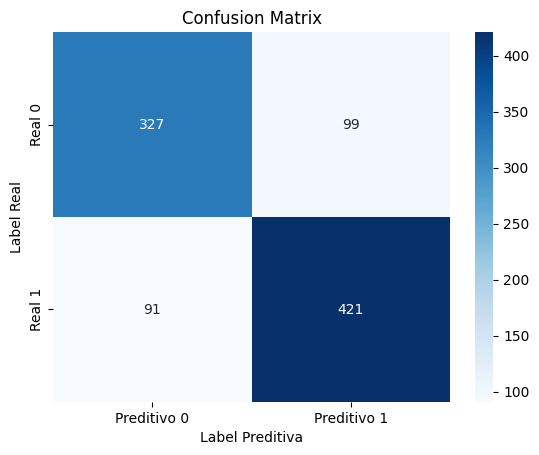

In [65]:
# Gráfico de Matriz de Confusão do resultado do modelo
conf_matrix = confusion_matrix(y_test_shap, y_pred_shap)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Preditivo 0", "Preditivo 1"], 
            yticklabels=["Real 0", "Real 1"])
plt.title("Confusion Matrix")
plt.ylabel("Label Real")
plt.xlabel("Label Preditiva")
plt.show()

In [66]:
print("Relatório de Classificação:")
print(classification_report(y_test_shap, y_pred_shap))

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       426
           1       0.81      0.82      0.82       512

    accuracy                           0.80       938
   macro avg       0.80      0.79      0.80       938
weighted avg       0.80      0.80      0.80       938



In [67]:
with open("features_selecionadas.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    for item in features_shap:
        writer.writerow([item])

In [68]:
features_shap

['F0160',
 'F0020',
 'F0104_EFWPAPRJ',
 'F0034',
 'F1580',
 'F1373',
 'F1808',
 'F0021',
 'F0704',
 'F1492',
 'F0026',
 'F1704',
 'F2444',
 'F0035',
 'F0024',
 'F0624',
 'F3171',
 'F0041',
 'F0266',
 'F0671',
 'F1166_76UZJ3DD',
 'F0212',
 'F0170_CED8XTP8',
 'F0003_HZYQ6FXR',
 'F1367',
 'F0105_B7J9MI0P',
 'F0590',
 'F0588',
 'F1735_FP10K8LQ',
 'F0861',
 'F1079',
 'F0207',
 'F2865',
 'F1048',
 'F0661',
 'F0139',
 'F0098',
 'F0022',
 'F0118',
 'F0632',
 'F0037',
 'F0003_RXEQ18HG',
 'F0042',
 'F0604',
 'F0161',
 'F0664',
 'F0698',
 'F0156',
 'F0260',
 'F0522',
 'F1852',
 'F0083',
 'F1018',
 'F0904',
 'F0255',
 'F0001',
 'F0227',
 'F2341_XETMZEMK',
 'F0458',
 'F0734',
 'F1310',
 'F0675',
 'F0585',
 'F1793',
 'F1806',
 'F0665',
 'F0186',
 'F1637',
 'F1185_W3GBU9EB',
 'F1640',
 'F1552',
 'F0090',
 'F2205',
 'F0099',
 'F0457',
 'F0536',
 'F1002',
 'F0419',
 'F0965',
 'F1553',
 'F0257',
 'F1756_7B0K3QGX',
 'F0453',
 'F1547',
 'F2239',
 'F0310',
 'F2267',
 'F0700',
 'F1490',
 'F0862',
 'F0483',
